# A tabular Q-learning approach to price impact

In [1]:
import numba
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy.stats import binom
from numba import njit
from numba import prange, vectorize

In [2]:
%config InlineBackend.figure_format = "retina"
plt.rcParams["axes.spines.right"] = False
plt.rcParams["axes.spines.top"] = False

In [3]:
sns.set_palette("colorblind")

## Problem setup

Consider the signal-price dynamics
$$
\begin{aligned}
    S_t &= S_{t-1} + \rho\,(S_{t-1} - \bar{S}) + k_t,\\
    P_t &= P_{t-1} + S_t + j_t
\end{aligned}
$$
with
$$
\begin{aligned}
    k_t &= (X_{S_t} - f_S)\,\psi_S,\\
    j_t &= (X_{P_t} - f_P)\,\psi_P,\\
    p(X_{S_t}) &= {\rm Binom}(X_{S_t}\,\vert\,2\,f_S, q_S),\\
    p(X_{P_t} | a_t) &= {\rm Binom}(X_{P_t}\,\vert\,2\,f_P, \sigma(b\,a_t)),\\
    a_t &\in \{0, 1, \ldots, {\cal A}\}
\end{aligned}
$$
and constants
*  $f_S, f_P \in \mathbb{N}$ the signal and price force respectively,
*  $\psi_S, \psi_P > 0$ the signal and price stride respectively,
*  $\rho \geq 0$ the mean-reversion factor,
*  $q_s \in (0,1)$ signal probability, and
*  $b \geq 0$ the price impact parameter.

### Process modellling 

In [4]:
MAX_PRICE = 100
MAX_SIGNAL = 1 # max value of signal per side
MAX_INVENTORY = 10

In [5]:
@njit
def set_seed(seed):
    np.random.seed(seed)

@njit
def sigmoid(z): return 1 / (1 + np.exp(-z))


@njit
def clip(a, a_min, a_max):
    return np.minimum(a_max, np.maximum(a, a_min))


@njit
def step_signal(signal_prev, force_signal, reversion_factor, p, stride, signal_mid):
    k = np.random.binomial(2 * force_signal, p)
    k = (k - force_signal) * stride
    signal = signal_prev + reversion_factor * (signal_mid - signal_prev) + k
    signal = clip(signal, -MAX_SIGNAL, MAX_SIGNAL)
    return signal

@njit
def step_price(price_prev, signal, force_price, price_impact, action, stride):
    j = np.random.binomial(2 * force_price, sigmoid(action * price_impact))
    j = (j - force_price) * stride
    price = price_prev + signal + j
    price = clip(price, 0, MAX_PRICE)
    return price


@njit
def step_process(
    signal_prev, price_prev, 
    force_signal, reversion_factor, p, signal_mid, stride_signal,
    force_price, price_impact, action, stride_price,
):
    signal = step_signal(signal_prev, force_signal, reversion_factor, p, stride_signal, signal_mid)
    price = step_price(price_prev, signal, force_price, price_impact, action, stride_price)
    return signal, price

Text(0.5, 0, 'ix move')

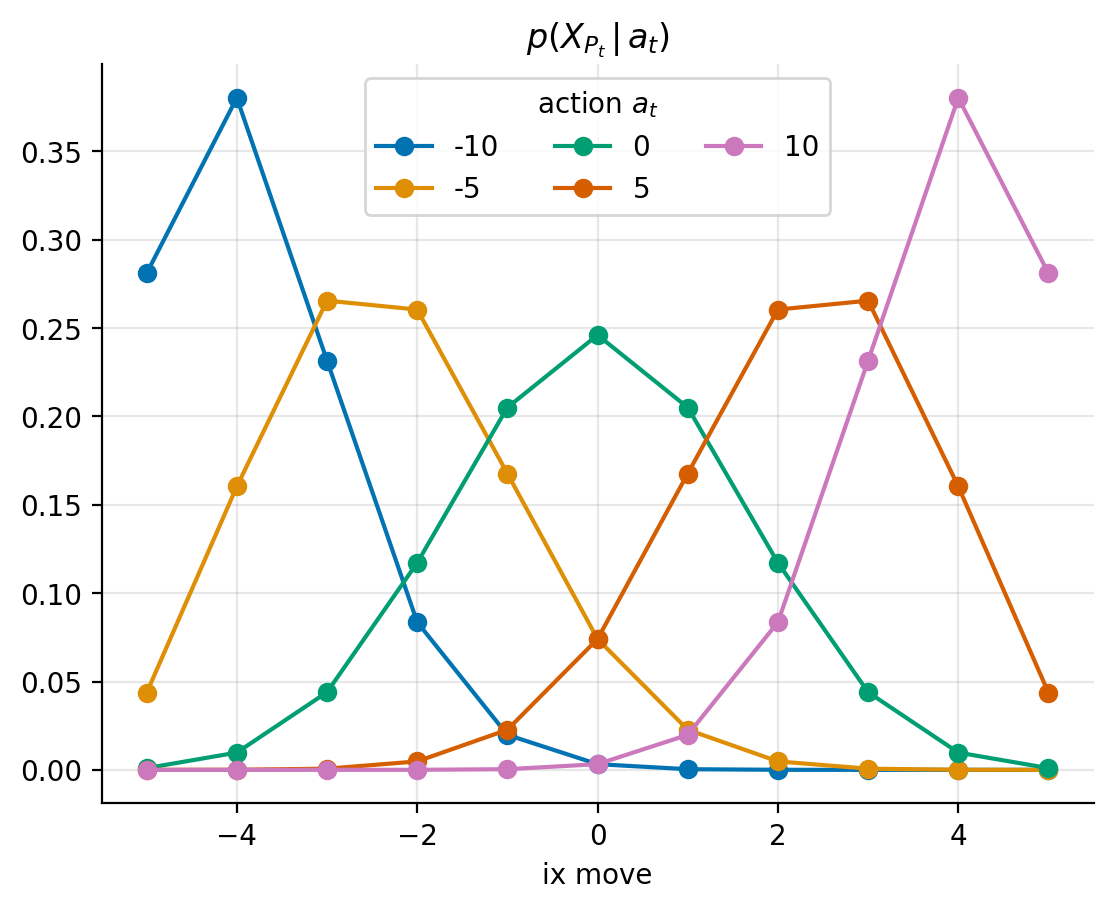

In [6]:
force_price = 5
price_impact = 0.2
prange = np.arange(0, 2 * force_price + 1)
ixrange = prange - force_price

for a in [-10, -5, 0, 5, 10]:
    dist = binom(2 * force_price, p=sigmoid(price_impact * a))
    probs = dist.pmf(prange)
    probs = probs / probs.sum()
    plt.plot(ixrange, probs, marker="o", label=a)
plt.grid(alpha=0.3)
plt.title(r"$p(X_{P_t}\,\vert\,a_t)$")
plt.legend(title="action $a_t$", ncol=3)
plt.xlabel("ix move")

In [7]:
force_signal = 5
force_price = 5
reversion_factor = 0.1
p = 0.5
stride_signal = 0.1
stride_price = 0.5
signal_mid = 0
price_impact = 0.2
signal = 0.0
price = 10.0

prices = []
signals = []
action = 0
set_seed(314)
for i in range(100):
    signal, price = step_process(
        signal, price,
        force_signal, reversion_factor, p, signal_mid, stride_signal,
        force_price, price_impact, action, stride_price
    )
    prices.append(price)
    signals.append(signal)

Text(0.5, 0, 'time ($t$)')

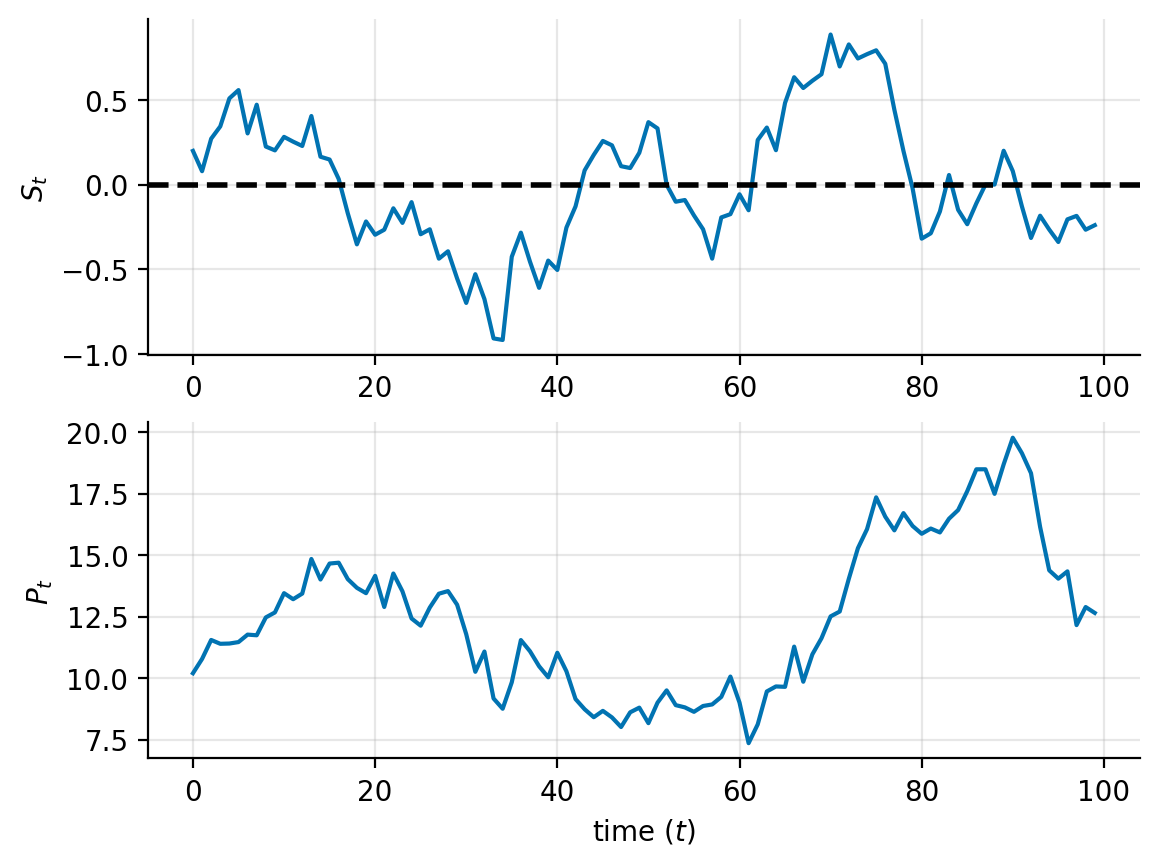

In [8]:
fig, axs = plt.subplots(2, 1)

axs[0].plot(signals)
axs[0].axhline(y=0, c="black", linewidth=2, linestyle="--")
axs[0].grid(alpha=0.3)
axs[0].set_ylabel("$S_t$")

axs[1].plot(prices)
axs[1].grid(alpha=0.3)
axs[1].set_ylabel("$P_t$")

axs[1].set_xlabel("time ($t$)")

# Towards $n$-step TD

## Value iteration
The Bellman equation for the optimal value function satisfies
$$
    v_*(s) = \max_a\sum_{s',r}
    \underbrace{
        p(s',r | s, a)
    }_\text{MDP}
    [r + \gamma v_*(s')].
$$

If the Markov decision process (MDP) is known, i.e., $p(s', r \vert s, a)$,
then the optimal value function can be found by value iteration.

In the the next block, we define the components that describe the MDP for the price impact problem.
The state in this problem are:
(i) the observed price,
(ii) the latent signal, and
(iii) the inventory.

### Evaluating the MDP

In [9]:
LOOKUP_TABLE = np.array([
    1, 1, 2, 6, 24, 120, 720, 5040, 40320,
    362880, 3628800, 39916800, 479001600,
    6227020800, 87178291200, 1307674368000,
    20922789888000, 355687428096000, 6402373705728000,
    121645100408832000, 2432902008176640000], dtype="int64")


@njit
def factorial(n):
    """
    reference:
    https://stackoverflow.com/a/44391133/11278455
    """
    if n > 20:
        raise ValueError
    return LOOKUP_TABLE[n]


@njit
def combinations(n, k):
    num = factorial(n)
    den = factorial(k) * factorial(n - k)
    return num / den


@vectorize(identity=1)
def pmf_uniform(x, x_low, x_high):
    pr = 1 / (x_high - x_low + 1)
    return pr * (x <= x_high) * (x >= x_low)


@vectorize(identity=1)
def pmf_binom(k, n, p):
    """
    Probability mass function (pmf) at x
    for a binomial ditribution with
    n trials and k successes

    TODO: make numerically stable
    """
    if k > n:
        return 0.0
    
    Z = combinations(n, k)
    pr =  Z * np.power(p, k) * np.power(1 - p, n - k)
    return pr

In [10]:
from numba.experimental import jitclass
from numba import float32, int32

spec = [
    ("force_price", int32),
    ("force_signal", int32),
    ("price_impact", float32),
    ("temporary_price_impact", float32),
    ("stride_signal", float32),
    ("stride_price", float32),
    ("signal_p", float32),
    ("signal_mid", float32),
    ("reversion_factor", float32),
    ("inventory_aversion", float32),
]

@jitclass(spec)
class MDP:
    def __init__(
        self, force_price, force_signal, price_impact, temporary_price_impact,
        stride_signal, stride_price, signal_mid, signal_p, reversion_factor, inventory_aversion
    ):
        self.force_price = force_price
        self.force_signal = force_signal
        self.price_impact = price_impact
        self.temporary_price_impact = temporary_price_impact
        self.stride_signal = stride_signal
        self.stride_price = stride_price
        self.signal_p = signal_p
        self.reversion_factor = reversion_factor
        self.inventory_aversion = inventory_aversion
        self.signal_mid = signal_mid

    
    def pr_transition_signal_fluctuation(self, Xs):
        """
        Probability mass function for the signal fluctuation (Xs)
        """
        # Xs = (signal - signal_prev - self.reversion_factor * (signal_prev - self.signal_mid)) / self.stride_signal
        # Xs = Xs + self.force_signal
        pr =  pmf_binom(Xs, 2 * self.force_signal, self.signal_p)
        return pr


    def pr_transition_price_fluctuation(self, Xp, action):
        """
        Probability masss function for the price fluctuation (Xp)
        """
        # Xp = (price - (price_prev + signal)) / self.stride_price
        # Xp = Xp + self.force_price
        pr = pmf_binom(Xp, 2 * self.force_price, sigmoid(action * self.price_impact))
        return pr

    
    def step_signal(self, Xs, signal_prev):
        """
        Parameters
        ----------
        Xs: float
            value in [0, 1, ..., 2 * self.force_signal] denoting the shift in signal
        signal_prev: float
            previous signal
        """
        kt = (Xs - self.force_signal) * self.stride_signal
        signal = signal_prev + self.reversion_factor * (self.signal_mid - signal_prev) + kt
        signal = clip(signal, -MAX_SIGNAL, MAX_SIGNAL)
        return signal

    
    def step_price(self, Xp, signal, price_prev):
        """
        Parameters
        ----------
        Xp: float
            value in [0, 1, ..., 2 * self.force_price] denoting the shift in price value
        signal: float
            observed signal
        price_prev: float
            past price value
        """
        jt = (Xp - self.force_price) * self.stride_price
        price = price_prev + signal + jt
        price = clip(price, 0, MAX_PRICE)
        return price

    def step_process(self, signal_prev, price_prev, action):
        price_p = sigmoid(action * self.price_impact)
        
        fluctuation_signal = np.random.binomial(2 * self.force_signal, self.signal_p)
        fluctuation_price = np.random.binomial(2 * self.force_price, price_p)

        signal = self.step_signal(fluctuation_signal, signal_prev)
        price = self.step_price(fluctuation_price, signal, price_prev)
        return signal, price

    
    def step_inventory(self, inventory_prev, action):
        return clip(inventory_prev + action, -MAX_INVENTORY, MAX_INVENTORY)


    def step_signal_price(self, fluctuation_price, fluctuation_signal, price_prev, signal_prev):
        signal = self.step_signal(fluctuation_signal, signal_prev)
        price = self.step_price(fluctuation_price, signal, price_prev)
        return signal, price

    
    def step_reward(
        self, fluctuation_price, fluctuation_signal, price_prev, signal_prev, inventory_prev, action
    ):

        signal, price = self.step_signal_price(fluctuation_price, fluctuation_signal, price_prev, signal_prev)
        inventory = self.step_inventory(inventory_prev, action)

        reward = (
            inventory * (price - price_prev) -
            action ** 2 * (self.inventory_aversion + self.temporary_price_impact) -
            2 * self.inventory_aversion * inventory_prev * action
        )
        state_next = (signal, price, inventory)
        return reward, state_next

    def value_function_iterate(
        self, signal_prev, price_prev, inventory_prev, V, discount
    ):
        value = 0.0
        for fl_signal in np.arange(2 * self.force_signal + 1):
            for fl_price in np.arange(2 * self.force_price + 1):
                ...

In [11]:
params = {
    "force_signal": 5,
    "force_price": 5,
    "price_impact": 0.2,
    "temporary_price_impact": 0.01,
    "stride_signal": 0.1,
    "stride_price": 0.5,
    "signal_p": 0.5,
    "reversion_factor": 0.1,
    "inventory_aversion": 1.0,
    "signal_mid": 0.0,
}

mdp = MDP(**params)

In [17]:
signal, price = 0, 10
action = 0

nsteps = 100
signals = np.zeros(nsteps)
prices = np.zeros(nsteps)

set_seed(314)
for i in range(100):
    signal, price = mdp.step_process(signal, price, action)
    signals[i] = signal
    prices[i] = price

Text(0.5, 1.0, 'Price')

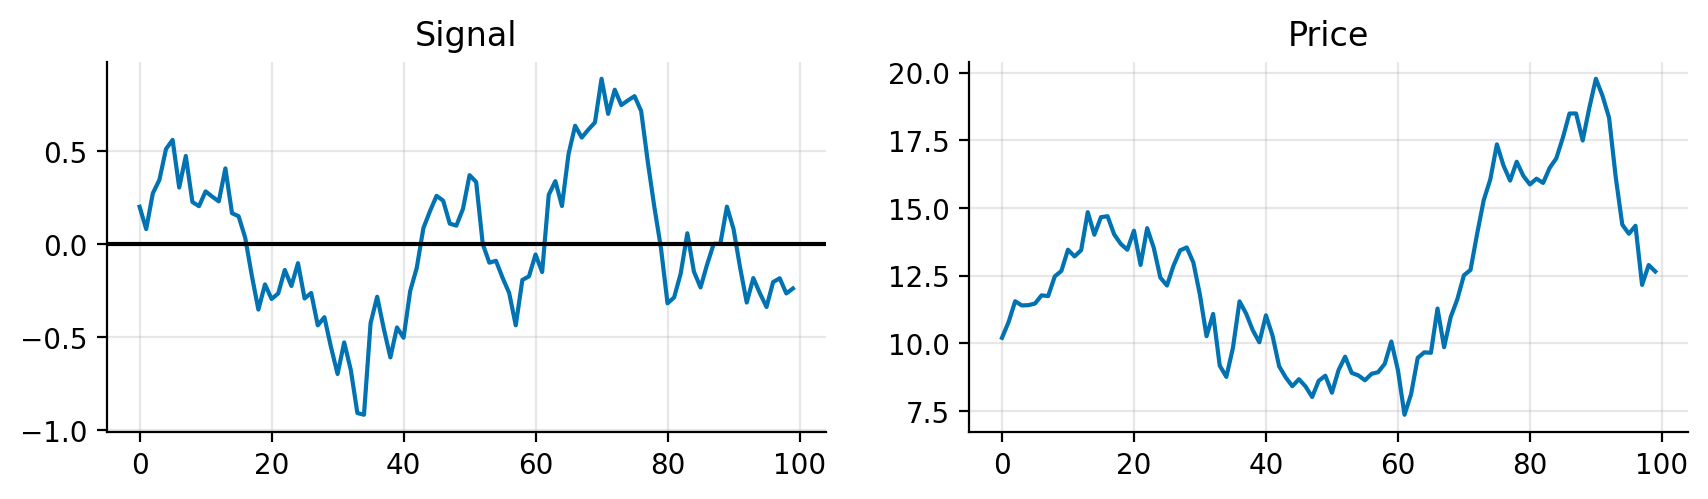

In [31]:
fig, ax = plt.subplots(1, 2, figsize=(6.8 * 1.5, 4.8 * 0.5))

ax[0].plot(signals)
ax[0].grid(alpha=0.3)
ax[0].set_title("Signal")
ax[0].axhline(y=0, c="black")

ax[1].plot(prices)
ax[1].grid(alpha=0.3)
ax[1].set_title("Price")

In [13]:
vals_signal = np.arange(-10, 10 + 1)
vals_price = np.arange(0, 200 + 1)

vals_signal = mdp.stride_signal * vals_signal
vals_price = mdp.stride_price * vals_price

In [14]:
V = clip(vals_price[:, None] + vals_signal[None, :], 0, MAX_PRICE)

In [15]:
np.unique(V)[:20]

array([0.        , 0.09999999, 0.09999999, 0.1       , 0.19999999,
       0.2       , 0.2       , 0.29999999, 0.3       , 0.3       ,
       0.39999999, 0.4       , 0.40000001, 0.49999999, 0.49999999,
       0.5       , 0.50000001, 0.59999999, 0.59999999, 0.6       ])

<Axes: >

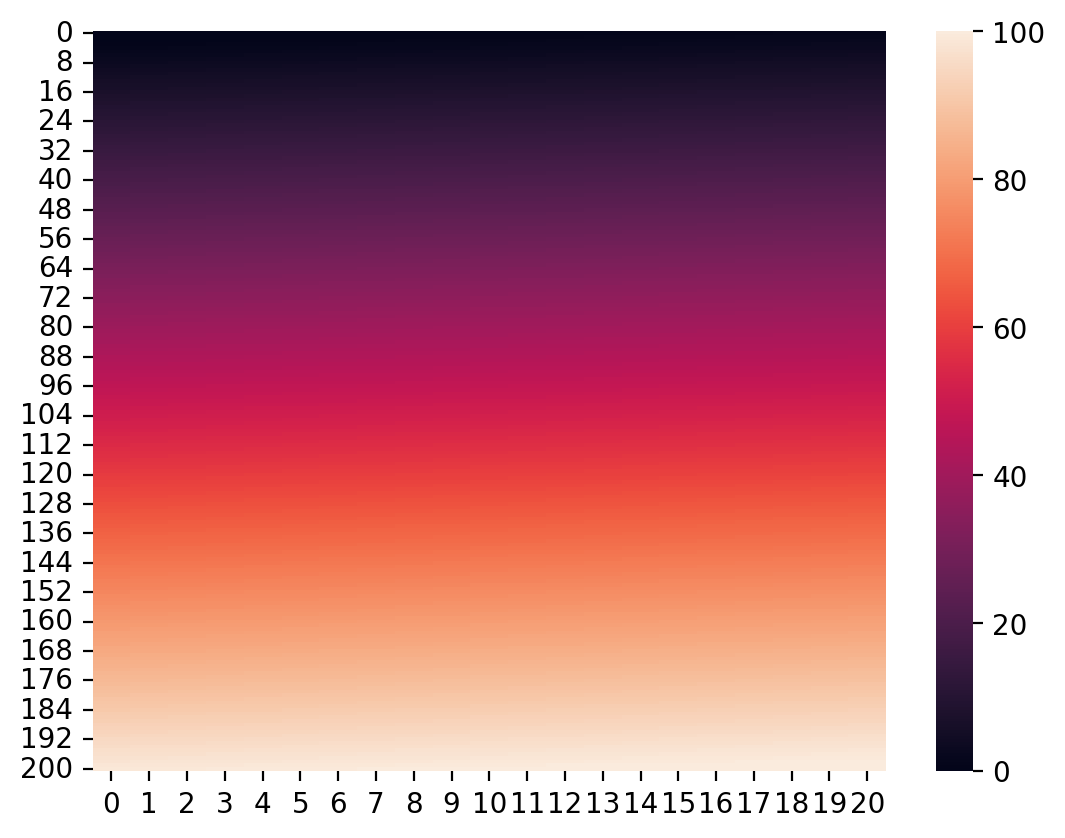

In [16]:
sns.heatmap(V)